In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests, json, gmplot
from datetime import datetime
from census import Census
# from us import states
from resources.states import states
from resources.statesAreaInMiles import statesAreaInMiles
import scipy.stats as stats
import plotly as py
from plotly.tools import FigureFactory as FF
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.gridspec import GridSpec
from bs4 import BeautifulSoup
from IPython.core.display import display
from IPython.display import IFrame
import matplotlib.patches as mpatches
import seaborn as sns


py.offline.init_notebook_mode(connected=True)

dt = datetime.today().strftime('%m-%d-%y')
# Extract API key from external json file
keyPairs = open('../../keys/appkey.json')
# Kristine's keys
# keyPairs = open('keys/appkey.json')
keyPairs_json = json.load(keyPairs)
gkey = keyPairs_json['gkey']
censuskey = keyPairs_json['censuskey']


## Extract Superfund Sites data

In [2]:
sf = pd.read_csv("resources/superfunddata.csv" , dtype={'Zip': str}) #, "Latitude":float
sf["Latitude"] = sf["Latitude"].str.decode("unicode_escape")
sf["Longitude"] = sf["Longitude"].str.decode("unicode_escape")
sf["Latitude"] = sf["Latitude"].str.encode("ascii", "ignore")
sf["Longitude"] = sf["Longitude"].str.encode("ascii", "ignore")
# delete empty rows at end of file
sf.drop(sf.index[[1336,1337]], inplace=True)
sf["Converted Date"] = ""
for index, row in sf.iterrows():
    sf.set_value(index, "Converted Date", datetime.strptime(row["Final Date"], '%m/%d/%y'))
sf["Year"]=""
for index, row in sf.iterrows():
    sf.set_value(index, "Year", row["Converted Date"].year)
sf.head()

,Reg,St,Site Name,Unnamed: 3,Site ID,EPA ID,Address,City,Zip,County,Unnamed: 10,Unnamed: 11,FF?,Latitude,Longitude,Final Date,Unnamed: 16,Unnamed: 17,Converted Date,Year
0,‭01‬,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,NaN,‭0100255‬,CTD980732333,ROUTE 44,BARKHAMSTED,06063,LITCHFIELD,NaN,NaN,N,b'+41.980550',b'-073.047220 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
1,‭01‬,CT,BEACON HEIGHTS LANDFILL,NaN,‭0100180‬,CTD072122062,BLACKBERRY HILL ROAD,BEACON FALLS,06403,NEW HAVEN,NaN,NaN,N,b'+41.431950',b'-073.035280 ',09/08/83,NaN,NaN,1983-09-08 00:00:00,1983
2,‭01‬,CT,DURHAM MEADOWS,NaN,‭0100108‬,CTD001452093,124 MAIN ST,DURHAM,06422,MIDDLESEX,NaN,NaN,N,b'+41.481110',b'-072.681380 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
3,‭01‬,CT,GALLUP'S QUARRY,NaN,‭0100201‬,CTD108960972,ROUTE 12,PLAINFIELD,06374,WINDHAM,NaN,NaN,N,b'+41.665280',b'-071.924160 ',10/04/89,NaN,NaN,1989-10-04 00:00:00,1989
4,‭01‬,CT,KELLOGG-DEERING WELL FIELD,NaN,‭0100252‬,CTD980670814,NORWALK WATER DEPARTMENT,NORWALK,06856,FAIRFIELD,NaN,NaN,N,b'+41.130550',b'-073.431950 ',09/21/84,NaN,NaN,1984-09-21 00:00:00,1984


## Find Superfund sites per State

In [3]:
## Extract statewise superfund site count, add state names against abbreviations & area of states in sq. miles 
sitesPerState = sf.groupby('St').count()
sitesPerState = sitesPerState.reset_index()
sitesPerState = sitesPerState[['St','Reg']]
sitesPerState = sitesPerState.rename(columns= {'St':'Code','Reg':'No. Of SF Sites'})
for state in states:
    if state not in sitesPerState['Code'].tolist():
        nxtIdx = len(sitesPerState)
        sitesPerState.set_value(nxtIdx, 'Code', state)
        sitesPerState.set_value(nxtIdx, 'No. Of SF Sites', 0)

sitesPerState['Name'] = sitesPerState['Code'].map(states.get)
sitesPerState['Area Sq Miles'] = sitesPerState['Name'].map(statesAreaInMiles.get)
sitesPerState['No. Of Sites Per Sq Miles'] = sitesPerState['No. Of SF Sites'].astype('float') / sitesPerState['Area Sq Miles'].astype('float')
sitesPerState.dropna(inplace=True)
sitesPerState.head()

,Code,No. Of SF Sites,Name,Area Sq Miles,No. Of Sites Per Sq Miles
0,AK,6.0,Alaska,571951.26,0.000010
1,AL,12.0,Alabama,50744.00,0.000236
2,AR,9.0,Arkansas,52068.17,0.000173
3,AZ,9.0,Arizona,113634.57,0.000079
4,CA,98.0,California,155959.34,0.000628


## Data munging (cleanse)

In [4]:
## Remove unwanted/blank columns, create list of latitudes & longitudes
# This data is needed for plotting on google map
sf.drop(['Unnamed: 3','Unnamed: 10','Unnamed: 11','Unnamed: 16','Unnamed: 17'], axis=1,inplace=True)
sfFilterLatLon = sf.copy()
sfFilterLatLon.drop(sfFilterLatLon.index[[756,1104]], inplace=True)
sfFilterLatLon.dropna(subset=[['Latitude','Longitude']],inplace=True)
sfFilterLatLon.reset_index(inplace=True)
latitudes = pd.to_numeric(sfFilterLatLon['Latitude'])
longitudes = pd.to_numeric(sfFilterLatLon['Longitude'])
sfFilterLatLon['Site Name'] = sfFilterLatLon['Site Name                                                                ']
sitename = sfFilterLatLon['Site Name'].tolist()

## Extract Census data for 2015 for all US zip codes

In [5]:
c = Census(censuskey, year=2015)
# censusByZipCd2015 = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_002E", "B23025_007E", "B23025_003E", "B23025_004E", "B23025_005E", "B23025_006E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B15003_002E", "B15003_017E", "B15003_018E", "B15003_021E", "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
# censusByZipCd2015_df = pd.DataFrame(censusByZipCd2015)
# censusByZipCd2015_df.head()

## Extract Census data for 2015 for all US States

In [6]:
censusByStates2015 = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B19301_001E", "B25077_001E"), {'for': 'state:*'})
censusByStates2015_df = pd.DataFrame(censusByStates2015)
censusByStates2015_df = censusByStates2015_df.rename(columns={"B01003_001E": "Population", 
                                                              "B19013_001E": "Household Income",
                                                              "B19301_001E": "Per Capita Income",
                                                              "B25077_001E": "Median House Price",
                                                              "NAME": "Name", "state": "State"})
censusByStates2015_df.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State
0,733375,72515,33413,250000,Alaska,02
1,4830620,43623,24091,125500,Alabama,01
2,2958208,41371,22798,111400,Arkansas,05
3,6641928,50255,25848,167500,Arizona,04
4,38421464,61818,30318,385500,California,06


## Merge Census data for States with Superfund sites data per State

In [7]:
censusStateAndSFSites = pd.merge(censusByStates2015_df,sitesPerState,on='Name')
censusStateAndSFSites['Population Density'] = censusStateAndSFSites['Population'].astype('int') / censusStateAndSFSites['Area Sq Miles'].astype('float')
censusStateAndSFSites.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State,Code,No. Of SF Sites,Area Sq Miles,No. Of Sites Per Sq Miles,Population Density
0,733375,72515,33413,250000,Alaska,02,AK,6.0,571951.26,0.000010,1.282233
1,4830620,43623,24091,125500,Alabama,01,AL,12.0,50744.00,0.000236,95.195885
2,2958208,41371,22798,111400,Arkansas,05,AR,9.0,52068.17,0.000173,56.814134
3,6641928,50255,25848,167500,Arizona,04,AZ,9.0,113634.57,0.000079,58.449889
4,38421464,61818,30318,385500,California,06,CA,98.0,155959.34,0.000628,246.355646


## Plot Statewise Superfund Sites density and Population density

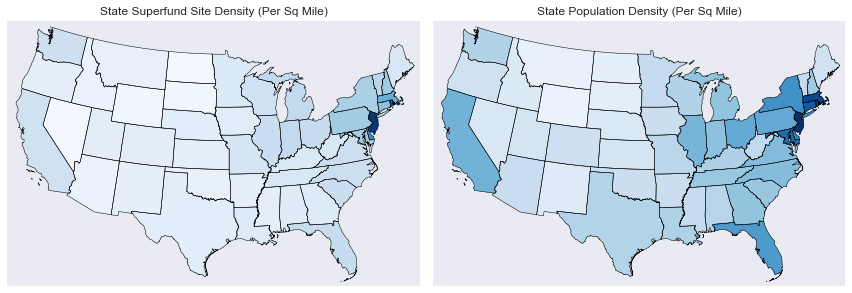

In [8]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('resources/st99_d00','states',drawbounds=True)
colors={}
statenames=[]
cmap = plt.cm.Blues_r
vmin = 0.000001; vmax = censusStateAndSFSites["No. Of Sites Per Sq Miles"].max() / censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico and the ones which are already processed. Process all from state_list of sitesPerSt
    if ((statename not in ['District of Columbia','Puerto Rico']) and (statename not in statenames) and (statename in censusStateAndSFSites["Name"].tolist())):
        if (int(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["No. Of SF Sites"])) == 0:
            pop = 0.00001/censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()
        else:
            pop = float(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["No. Of Sites Per Sq Miles"]) / censusStateAndSFSites["No. Of Sites Per Sq Miles"].sum()
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if (statenames[nshape] not in ['District of Columbia','Puerto Rico']):
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

plt.title('State Superfund Site Density (Per Sq Mile)')


plt.subplot(1,2,2)
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile('resources/st99_d00','states',drawbounds=True)
colors={}
statenames=[]
cmap = plt.cm.Blues_r
vmin = censusStateAndSFSites["Population Density"].min()/censusStateAndSFSites["Population Density"].sum(); vmax = censusStateAndSFSites["Population Density"].max()/censusStateAndSFSites["Population Density"].sum()

for shapedict in m.states_info:
    statename = shapedict['NAME']
    if (statename not in ['District of Columbia','Puerto Rico']) and (statename not in statenames) and (statename in censusStateAndSFSites["Name"].tolist()):
        pop = (int(censusStateAndSFSites[censusStateAndSFSites["Name"] == statename]["Population Density"]) * 10 / censusStateAndSFSites["Population Density"].sum())
        colors[statename] = cmap(1.-np.sqrt(((pop-vmin)/(vmax-vmin))))[:3]
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.title('State Population Density (Per Sq Mile)')

plt.tight_layout()
plt.show()

In [9]:
censusStateAndSFSites.head()

,Population,Household Income,Per Capita Income,Median House Price,Name,State,Code,No. Of SF Sites,Area Sq Miles,No. Of Sites Per Sq Miles,Population Density
0,733375,72515,33413,250000,Alaska,02,AK,6.0,571951.26,0.000010,1.282233
1,4830620,43623,24091,125500,Alabama,01,AL,12.0,50744.00,0.000236,95.195885
2,2958208,41371,22798,111400,Arkansas,05,AR,9.0,52068.17,0.000173,56.814134
3,6641928,50255,25848,167500,Arizona,04,AZ,9.0,113634.57,0.000079,58.449889
4,38421464,61818,30318,385500,California,06,CA,98.0,155959.34,0.000628,246.355646


## Plot Superfund Site counts and Census data on US Map

In [10]:
censusStateAndSFSitesStr = censusStateAndSFSites.copy()
for col in censusStateAndSFSitesStr.columns:
    censusStateAndSFSitesStr[col] = censusStateAndSFSitesStr[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

censusStateAndSFSitesStr['text'] = censusStateAndSFSitesStr['Name'] + '<br>' +\
    'No. Of Sites/Sq Mile: '+censusStateAndSFSitesStr['No. Of Sites Per Sq Miles']+ '<br>' +\
    'Population/Sq Mile: '+censusStateAndSFSitesStr['Population Density']+ '<br>' +\
    'Household Income: '+censusStateAndSFSitesStr['Household Income'] + '<br>' +\
    'Per Capita Income: '+censusStateAndSFSitesStr['Per Capita Income'] + '<br>' +\
    'Median House Price: '+censusStateAndSFSitesStr['Median House Price']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = censusStateAndSFSitesStr['Code'],
        z = censusStateAndSFSitesStr['No. Of SF Sites'].astype(float),
        locationmode = 'USA-states',
        text = censusStateAndSFSitesStr['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "No Of Sites")
        ) ]

layout = dict(
        title = 'Number of Superfund sites as of 2016<br> [Hover for breakdown]',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.offline.iplot( fig, filename='d3-cloropleth-map' )


In [11]:
#Function to update Google api key in code for code generated by gmplot
def insertapikey(fname, apikey):
    """put the google api key in a html file"""
    def putkey(htmltxt, apikey, apistring=None):
        """put the apikey in the htmltxt and return soup"""
        if not apistring:
            apistring = "https://maps.googleapis.com/maps/api/js?key=%s&callback=initMap"
        soup = BeautifulSoup(htmltxt, 'html.parser')
        body = soup.body
        src = apistring % (apikey, )
        tscript = soup.new_tag("script", src=src, async="defer")
        body.insert(-1, tscript)
        return soup
    htmltxt = open(fname, 'r').read()
    soup = putkey(htmltxt, apikey)
    newtxt = soup.prettify()
    open(fname, 'w').write(newtxt)

## Plot all Superfund sites on Google map 

In [12]:
fname = "allSFSites.html"
gmap = gmplot.GoogleMapPlotter(37.428, -95.145, 4)
for x in range(len(longitudes)):
    gmap.circle(latitudes[x],longitudes[x], 3000, "r", ew=1)
gmap.draw(fname)  

insertapikey(fname, gkey)
display(IFrame(fname, width=800, height=400))

In [13]:
cur_addr = "300 atrium drive somerset nj"
target_url = "https://maps.googleapis.com/maps/api/geocode/json" \
    "?address=%s&key=%s" % (cur_addr, gkey)
geo_data = requests.get(target_url).json()
lat = geo_data["results"][0]["geometry"]["location"]["lat"]
lon = geo_data["results"][0]["geometry"]["location"]["lng"]

## Plot markers for all Superfund sites near a specific location

### (300 Atrium Drive, Somerset, NJ)

In [14]:
fname = "nearbySFSites.html"
gmap = gmplot.GoogleMapPlotter(lat, lon, 12)
for x in range(len(longitudes)):
    gmap.marker(latitudes[x],longitudes[x], title=sitename[x])
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"
gmap.draw(fname) 

insertapikey(fname, gkey)
display(IFrame(fname, width=800, height=400))

## Extract Census data of 2011 to 2015 for all US zip codes

In [15]:
census_df_all = pd.DataFrame([])
yrs = [2011,2012,2013,2014,2015]
for x in yrs:
    c = Census(censuskey, year=x)
    census_df_tmp = pd.DataFrame([])
    census_df_tmp['Year'] = ""
    # removed following as not available for all years - B23025_002E, B23025_007E, B23025_003E, B23025_004E, B23025_005E, B23025_006E, B15003_002E, B15003_017E, B15003_018E, B15003_021E, B15003_022E, B15003_023E, B15003_024E, B15003_025E
    census_data = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
    census_df_tmp = pd.DataFrame(census_data)
    census_df_tmp['Year'] = x
    census_df_all = census_df_all.append(census_df_tmp)
census_df_all.head()

In [16]:
zips, population, house_value, age, capita, income, poverty, year = [[] * 8 for x in range(8)]
for index, row in sf.iterrows():
    if row["Converted Date"].year == int("2009"):
        zips.append(row["Zip"])
for index, row in census_df_all.iterrows():
    for code in zips:
        if (code == row["zip code tabulation area"]):
            population.append(row['B01003_001E'])
            house_value.append(row['B25077_001E'])
            age.append(row['B01002_001E'])
            capita.append(row['B19301_001E'])
            income.append(row['B19013_001E'])
            poverty.append(row['B17001_002E'])
            year.append(row["Year"])

sf_census = pd.DataFrame({
    "Population":population,
    "House Value":house_value,
    "Age":age,
    "Per Capita Income":capita,
    "Income":income,
    "Number Below Poverty":poverty,
    "Year":year
})
new_sf = sf_census.apply(pd.to_numeric)
five_year_sf = new_sf.groupby("Year").mean()

norm_census = pd.DataFrame({
    "Population":census_df_all["B01003_001E"],
    "House Value":census_df_all["B25077_001E"],
    "Age":census_df_all["B01002_001E"],
    "Per Capita Income":census_df_all["B19301_001E"],
    "Income":census_df_all["B19013_001E"],
    "Number Below Poverty":census_df_all["B17001_002E"],
    "Year":census_df_all["Year"]
})
norm_census = norm_census.apply(pd.to_numeric)
five_year_norm = norm_census.groupby("Year").mean()

## Socio-Economic trends Superfund Sites vs National (2011-2015)

In [17]:
plt.figure(figsize=(18,3))
plt.subplot(1,5,1)
plt.plot(five_year_sf.index,five_year_sf["House Value"], c='b')
plt.plot(five_year_norm.index, five_year_norm["House Value"],c='r')
plt.title("Median Home Price")
plt.subplot(1,5,2)
plt.plot(five_year_sf.index,five_year_sf["Population"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Population"],c='r')
plt.title("Population")
plt.subplot(1,5,3)
plt.plot(five_year_sf.index,five_year_sf["Income"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Income"],c='r')
plt.title("Household Income")
plt.subplot(1,5,4)
plt.plot(five_year_sf.index,five_year_sf["Per Capita Income"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Per Capita Income"],c='r')
plt.title("Per Capita Income")
plt.subplot(1,5,5)
plt.plot(five_year_sf.index,five_year_sf["Number Below Poverty"], c='b')
plt.plot(five_year_norm.index, five_year_norm["Number Below Poverty"],c='r')
plt.title("No. of People Below Poverty")
plt.tight_layout()
label1 = ["Superfund Site Location's mean for each year(2011-2015)","National mean for each year(2011-2015)"]
plt.legend(labels=label1, bbox_to_anchor=(-1.2, -0.1))
plt.show()

## Plot Superfund site counts per state

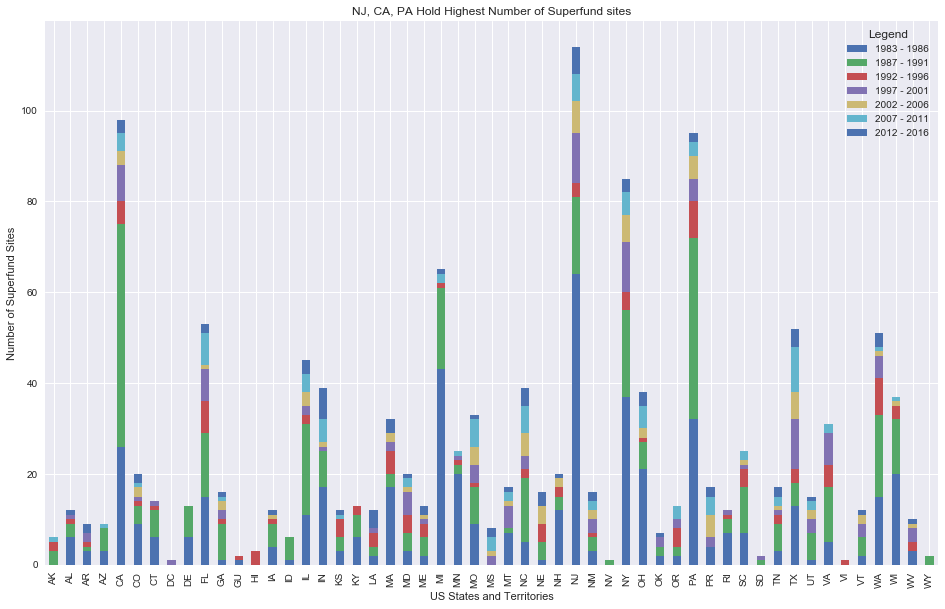

In [18]:
yearRange = [1983, 1987, 1992, 1997, 2002, 2007, 2012, 2017]
rangeLabel = []
for index, x in enumerate(yearRange):
    if index == 0:
        rangeLabel.append(str(x) + " - " + str(x+3))
    elif index != len(yearRange)-1:
        rangeLabel.append(str(x) + " - " + str(x+4)) 
rangeLabel
sf["YearRange"] = pd.cut(sf["Year"], yearRange, labels=rangeLabel, include_lowest=True, right=False)
sf[sf["YearRange"]=="2012 - 2016"].sort_values("Year")
stateYear = pd.crosstab(sf['St'], sf['YearRange'])

stateYear.plot(kind="bar", stacked=True, figsize=(16,10))
plt.legend(bbox_to_anchor=(1,1),
           ncol=1, shadow=True, title="Legend", fancybox=False)
plt.title("NJ, CA, PA Hold Highest Number of Superfund sites")
plt.ylabel("Number of Superfund Sites")
plt.xlabel("US States and Territories")
plt.show()

## Merge superfund and census 2015 data

In [19]:
c = Census(censuskey, year=2015)
censusByZipCd2015 = c.acs5.get(("NAME", "B19013_001E", "B19301_001E", "B23025_002E", "B23025_007E", "B23025_003E", "B23025_004E", "B23025_005E", "B23025_006E", "C24010_003E", "C24010_004E", "C24010_005E", "C24010_006E", "C24010_007E", "C24010_008E", "C24010_009E", "C24010_010E", "C24010_011E", "C24010_012E", "C24010_013E", "C24010_014E", "C24010_015E", "C24010_016E", "C24010_017E", "C24010_018E", "C24010_019E", "C24010_020E", "C24010_021E", "C24010_022E", "C24010_023E", "C24010_024E", "C24010_025E", "C24010_026E", "C24010_027E", "C24010_028E", "C24010_029E", "C24010_030E", "C24010_031E", "C24010_032E", "C24010_033E", "C24010_034E", "C24010_035E", "C24010_036E", "C24010_037E", "C24010_039E", "C24010_040E", "C24010_041E", "C24010_042E", "C24010_043E", "C24010_044E", "C24010_045E", "C24010_046E", "C24010_047E", "C24010_048E", "C24010_049E", "C24010_050E", "C24010_051E", "C24010_052E", "C24010_053E", "C24010_054E", "C24010_055E", "C24010_056E", "C24010_057E", "C24010_058E", "C24010_059E", "C24010_060E", "C24010_061E", "C24010_062E", "C24010_063E", "C24010_064E", "C24010_065E", "C24010_066E", "C24010_067E", "C24010_068E", "C24010_069E", "C24010_070E", "C24010_071E", "C24010_072E", "C24010_073E", "B17001_002E", "B17001_003E", "B17001_017E", "B17001A_002E", "B17001B_002E", "B17001C_002E", "B17001D_002E", "B17001E_002E", "B17001G_002E", "B17001I_002E", "B17012_002E", "B17012_003E", "B17012_009E", "B17012_014E", "B01002_001E", "B01002_002E", "B01002_003E", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E", "B25035_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E", "B08136_003E", "B08136_004E", "B08136_007E", "B08136_011E", "B08136_012E", "B08301_001E", "B08301_003E", "B08301_004E", "B08301_010E", "B08301_019E", "B08101_041E", "B15003_002E", "B15003_017E", "B15003_018E", "B15003_021E", "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E", "B16001_002E", "B16001_003E", "B16001_006E", "B16001_009E", "B16001_012E", "B16001_015E", "B16001_018E", "B16001_021E", "B16001_030E", "B16001_033E", "B16001_036E", "B16001_039E", "B16001_045E", "B16001_048E", "B16001_051E", "B16001_054E", "B16001_057E", "B16001_066E", "B16001_069E", "B16001_072E", "B16001_075E", "B16001_078E", "B16001_081E", "B16001_084E", "B16001_087E", "B16001_093E", "B16001_099E", "B16001_105E", "B16001_108E", "B16001_111E"), {'for': 'zip code tabulation area:*'})
censusByZipCd2015_df = pd.DataFrame(censusByZipCd2015)
censusByZipCd2015_df.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_008E,...,C24010_066E,C24010_067E,C24010_068E,C24010_069E,C24010_070E,C24010_071E,C24010_072E,C24010_073E,NAME,zip code tabulation area
0,37.6,36.5,39,17982,16956,102,14,0,0,64,...,14,0,0,14,125,110,0,15,ZCTA5 00601,00601
1,39.5,38.6,40.3,40260,23144,693,8,72,0,14798,...,15,0,0,15,376,334,0,42,ZCTA5 00602,00602
2,39.9,37.7,41.4,52408,36177,2057,76,655,0,7801,...,43,0,11,32,211,128,0,83,ZCTA5 00603,00603
3,40.8,41,40.3,6331,4399,151,0,0,0,126,...,15,0,0,15,93,93,0,0,ZCTA5 00606,00606
4,40.2,36.9,42.2,28328,17791,950,0,26,0,3355,...,0,0,0,0,788,738,15,35,ZCTA5 00610,00610


In [20]:
# B15003_002E - None
# B15003_017E - High School
# B15003_018E - GED
# B15003_021E - Associate
# B15003_022E - Bachelors
# B15003_023E - Masters
# B15003_024E - Professional
# B15003_025E - Doctorate (Phd)

# B25088_002E - median_monthly_owner_costs
# B25064_001E - gross rent
# B19013_001E - median hh income

In [81]:
# convert the population columns to numeric 
cols=[i for i in censusByZipCd2015_df.columns if i not in ['NAME','zip code tabulation area']]
for col in cols:
    censusByZipCd2015_df[col]=pd.to_numeric(censusByZipCd2015_df[col])

# rename these columns    
censusByZipCd2015_df.rename(columns={"B02001_002E":"White Alone", \
                          "B02001_003E":"Black Alone", \
                          "B02001_004E": "American Indian or Alaskan Native Alone", \
                          "B02001_005E": "Asian Alone", \
                          "B02001_006E": "Native Hawaiian and Other Pacific Islander Alone", \
                          "B02001_008E": "Two or more races", \
                          "B03001_003E": "Hispanic Origin", \
                          "B15003_002E":"Edu_None", \
                          "B15003_017E": "Edu_HighSchool", \
                          "B15003_018E": "Edu_GED", \
                          "B15003_021E": "Edu_Associate", \
                          "B15003_022E": "Edu_Bachelors", \
                          "B15003_023E": "Edu_Masters", \
                          "B15003_024E": "Edu_Professional", \
                          "B15003_025E": "Edu_Doctorate(Phd)", \
                          "B23025_002E": "LaborForce_Emp", \
                          "B23025_007E": "LaborForce_UnEmp"}, inplace=True) 

censusByZipCd2015_df["incomeOwning"] = censusByZipCd2015_df["B25088_002E"].dropna()*12/censusByZipCd2015_df["B19013_001E"].dropna()
censusByZipCd2015_df["incomeRenting"] = (censusByZipCd2015_df["B25064_001E"].dropna() * 12)/censusByZipCd2015_df["B19013_001E"].dropna()

censusByZipCd2015_df["LaborForce_Total"] = censusByZipCd2015_df[['LaborForce_Emp','LaborForce_UnEmp']].sum(axis=1)
censusByZipCd2015_df["LaborForce_Emp_Ratio"] = censusByZipCd2015_df['LaborForce_Emp']/censusByZipCd2015_df["LaborForce_Total"]

censusByZipCd2015_df["Pop_Total"] = censusByZipCd2015_df[["Black Alone", "White Alone", "American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]].sum(axis=1)
censusByZipCd2015_df["White Ratio"] = censusByZipCd2015_df["White Alone"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Black Ratio"] = censusByZipCd2015_df["Black Alone"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Native Ratio"] = censusByZipCd2015_df["American Indian or Alaskan Native Alone"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Asian Ratio"] = censusByZipCd2015_df["Asian Alone"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Hispanic Ratio"] = censusByZipCd2015_df["Hispanic Origin"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Islander Ratio"] = censusByZipCd2015_df["Native Hawaiian and Other Pacific Islander Alone"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["TwoRace Ratio"] = censusByZipCd2015_df["Two or more races"] / censusByZipCd2015_df["Pop_Total"]
censusByZipCd2015_df["Non-White Ratio"] = 1 - censusByZipCd2015_df["White Ratio"]

censusByZipCd2015_df["Edu_HSAndBelow"] = censusByZipCd2015_df[['Edu_None','Edu_HighSchool','Edu_GED']].sum(axis=1)
censusByZipCd2015_df["Edu_Undergrad"] = censusByZipCd2015_df[['Edu_Associate','Edu_Bachelors']].sum(axis=1)
censusByZipCd2015_df["Edu_Graduate"] = censusByZipCd2015_df[['Edu_Masters','Edu_Professional','Edu_Doctorate(Phd)']].sum(axis=1)


censusByZipCd2015_df["Edu_Total"] = censusByZipCd2015_df[['Edu_HSAndBelow','Edu_Undergrad','Edu_Graduate']].sum(axis=1)

censusByZipCd2015_df["Edu_HSAndBelow_Ratio"] = censusByZipCd2015_df["Edu_HSAndBelow"] / censusByZipCd2015_df["Edu_Total"]
censusByZipCd2015_df["Edu_Undergrad_Ratio"] = censusByZipCd2015_df["Edu_Undergrad"] / censusByZipCd2015_df["Edu_Total"]
censusByZipCd2015_df["Edu_Graduate_Ratio"] = censusByZipCd2015_df["Edu_Graduate"] / censusByZipCd2015_df["Edu_Total"]

# # This should not be done as the mean taken after this will not have '0' Population areas accounted for.
# censusByZipCd2015_df = censusByZipCd2015_df[censusByZipCd2015_df['Pop_Total'] != 0]

censusByZipCd2015_df.head()

,B01002_001E,B01002_002E,B01002_003E,B01003_001E,White Alone,Black Alone,American Indian or Alaskan Native Alone,Asian Alone,Native Hawaiian and Other Pacific Islander Alone,Two or more races,...,Islander Ratio,TwoRace Ratio,Non-White Ratio,Edu_HSAndBelow,Edu_Undergrad,Edu_Graduate,Edu_Total,Edu_HSAndBelow_Ratio,Edu_Undergrad_Ratio,Edu_Graduate_Ratio
0,37.6,36.5,39.0,17982,16956,102,14,0,0,64,...,0.0,0.001825,0.516620,3629,2335,372,6336,0.572759,0.368529,0.058712
1,39.5,38.6,40.3,40260,23144,693,8,72,0,14798,...,0.0,0.193701,0.697052,6729,7702,1706,16137,0.416992,0.477288,0.105720
2,39.9,37.7,41.4,52408,36177,2057,76,655,0,7801,...,0.0,0.080255,0.627820,10704,9128,2273,22105,0.484234,0.412938,0.102827
3,40.8,41.0,40.3,6331,4399,151,0,0,0,126,...,0.0,0.011456,0.600055,1703,540,70,2313,0.736273,0.233463,0.030264
4,40.2,36.9,42.2,28328,17791,950,0,26,0,3355,...,0.0,0.066938,0.645039,6887,3864,635,11386,0.604866,0.339364,0.055770


In [22]:
sfcensus = sf.merge(censusByZipCd2015_df, how="left", left_on="Zip", right_on="zip code tabulation area")
len(sfcensus)

1336

In [23]:
sfcensus.drop_duplicates(subset='Zip', keep="last", inplace=True)
len(sfcensus)

1156

In [24]:
# sfcensus["Total"] = sfcensus[["Black Alone", "White Alone", "American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]].sum(axis=1)
# censusByZipCd2015_df["Total"] = censusByZipCd2015_df[["Black Alone", "White Alone", "American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]].sum(axis=1)

# censusByZipCd2015_df = censusByZipCd2015_df[censusByZipCd2015_df['Total'] != 0]
# sfcensus = sfcensus[sfcensus['Total'] != 0]

In [101]:
# get the census data for zip codes that do not have SF sites 33120 - 1087
no_sf = censusByZipCd2015_df[censusByZipCd2015_df['zip code tabulation area'].isin(sf["Zip"])==False]

# pull a sample of zipcodes without SF sites that is same size as zipcode with SF sites
no_sf_subset = no_sf.sample(1087)

# pull a sample of zipcodes without SF sites that is same size as zipcode with SF sites
random_subset = censusByZipCd2015_df.sample(1087)


groups = ["Superfund Areas", "Nation", "Random No SF", "Random"]


## Population segment analysis

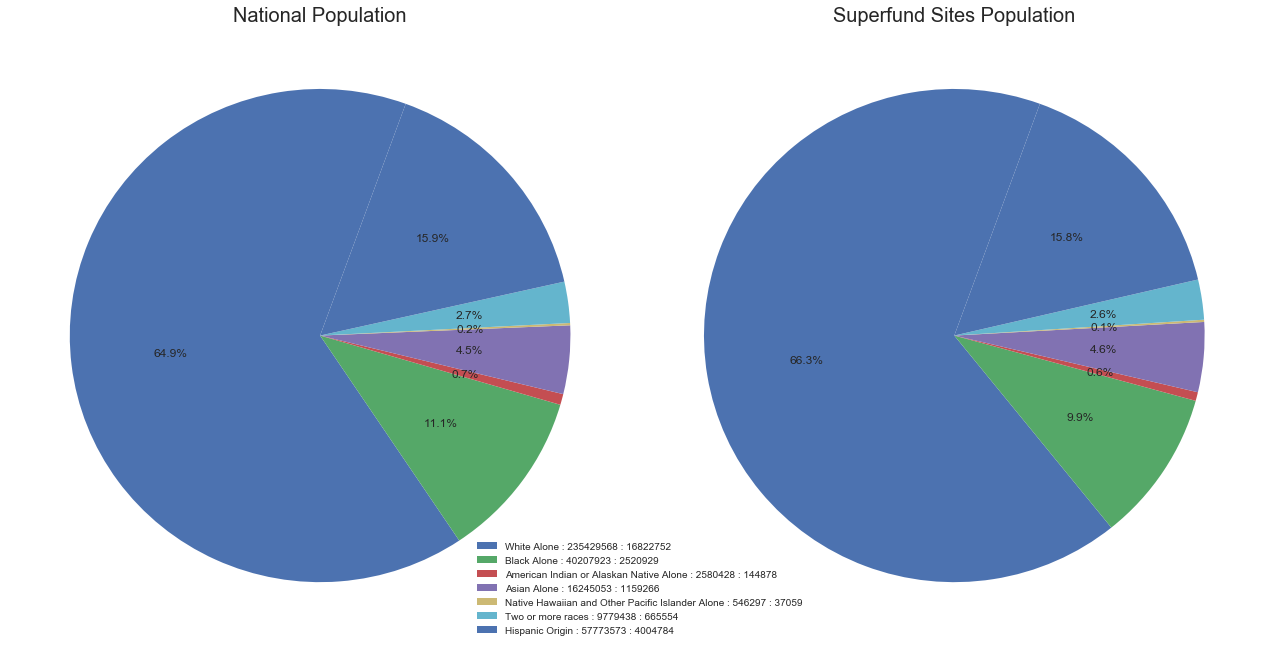

In [57]:
popLabels = ["White Alone", "Black Alone","American Indian or Alaskan Native Alone","Asian Alone","Native Hawaiian and Other Pacific Islander Alone","Two or more races","Hispanic Origin"]

nationalPopCount = []
for p in popLabels:
    nationalPopCount.append(pd.to_numeric(censusByZipCd2015_df[p]).sum())
    
sfPopCount = []
for p in popLabels:
    sfPopCount.append(pd.to_numeric(sfcensus[p]).sum())

fig = plt.figure(figsize=(18,18))
the_grid = GridSpec(2,2)

ax1 = fig.add_subplot(the_grid[0,0])
nationalPopSeries = pd.Series(nationalPopCount)
patches, texts,autotexts = ax1.pie(nationalPopSeries, autopct='%1.1f%%', startangle = 70)
ax1.set_title("National Population", size=20)

ax2 = fig.add_subplot(the_grid[0,1])
sfPopSeries = pd.Series(sfPopCount)
patches, texts,autotexts = ax2.pie(sfPopSeries, autopct='%1.1f%%', startangle = 70)
ax2.set_title("Superfund Sites Population", size=20)

label1 = ['{0} : {1:1d} : {2:1.0f} ' .format(x,y,z) for x,y,z in zip(popLabels, nationalPopCount, sfPopCount)]
plt.legend(loc='lower center', labels=label1, bbox_to_anchor=(0, 0))
plt.tight_layout(pad=1.5, w_pad=0.7, h_pad=0.5)
plt.show()

In [58]:
print("SF Population Mean %s " % ("{:,.2f}".format(sfcensus["Pop_Total"].mean())))
print("Nation Population Mean %s " % ("{:,.2f}".format(censusByZipCd2015_df["Pop_Total"].mean())))

SF Population Mean 23,325.87 
Nation Population Mean 11,050.36 


In [28]:
print("SF White Mean %s " % ("{:,.2f}".format(sfcensus["White Alone"].mean())))
print("Nation White Mean %s " % ("{:,.2f}".format(censusByZipCd2015_df["White Alone"].mean())))

SF White Mean 15,476.31 
Nation White Mean 7,175.54 


In [29]:
print("SF white RATIO mean %s" % ("{:.2f}%".format(sfcensus["White Ratio"].mean())))
print("Nation white RATIO mean %s" % ("{:.2f}%".format(censusByZipCd2015_df["White Ratio"].mean())))

SF white RATIO mean 0.73%
Nation white RATIO mean 0.80%


In [31]:
t, prob = stats.ttest_1samp(a=sfcensus["White Ratio"].dropna(), popmean=censusByZipCd2015_df["White Ratio"].dropna().mean())
print("White Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Black Ratio"].dropna(), popmean=censusByZipCd2015_df["Black Ratio"].dropna().mean())
print("Black Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Native Ratio"].dropna(), popmean=censusByZipCd2015_df["Native Ratio"].dropna().mean())
print("Native Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Asian Ratio"].dropna(), popmean=censusByZipCd2015_df["Asian Ratio"].dropna().mean())
print("Asian Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Islander Ratio"].dropna(), popmean=censusByZipCd2015_df["Islander Ratio"].dropna().mean())
print("Islander Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["TwoRace Ratio"].dropna(), popmean=censusByZipCd2015_df["TwoRace Ratio"].dropna().mean())
print("TwoRace Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Hispanic Ratio"].dropna(), popmean=censusByZipCd2015_df["Hispanic Ratio"].dropna().mean())
print("Hispanic Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=sfcensus["Non-White Ratio"].dropna(), popmean=censusByZipCd2015_df["Non-White Ratio"].dropna().mean())
print("Non-White Ratio: t= %f p-value= %f" % (t,prob))

White Ratio: t= -9.801092 p-value= 0.000000
Black Ratio: t= 4.272176 p-value= 0.000021
Native Ratio: t= -3.382093 p-value= 0.000745
Asian Ratio: t= 7.518870 p-value= 0.000000
Islander Ratio: t= 2.076169 p-value= 0.038113
TwoRace Ratio: t= 5.442988 p-value= 0.000000
Hispanic Ratio: t= 8.332358 p-value= 0.000000
Non-White Ratio: t= 9.801092 p-value= 0.000000


In [32]:
print("SF Mean Population %s" % "{:,.0f}".format(sfcensus["Pop_Total"].mean()))
print("Nation Mean Population %s" % "{:,.0f}".format(censusByZipCd2015_df["Pop_Total"].mean()))

SF Mean Population 23,326
Nation Mean Population 11,050


#### Population Results: The population is signifcantly higher in areas with Superfund sites

### Census Data without Superfund Sites - remove the zipcodes that have superfund sites

In [33]:
t, prob = stats.ttest_1samp(a=no_sf_subset["White Ratio"].dropna(), popmean=censusByZipCd2015_df["White Ratio"].dropna().mean())
print("White Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["Black Ratio"].dropna(), popmean=censusByZipCd2015_df["Black Ratio"].dropna().mean())
print("Black Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["Native Ratio"].dropna(), popmean=censusByZipCd2015_df["Native Ratio"].dropna().mean())
print("Native Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["Asian Ratio"].dropna(), popmean=censusByZipCd2015_df["Asian Ratio"].dropna().mean())
print("Asian Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["Islander Ratio"].dropna(), popmean=censusByZipCd2015_df["Islander Ratio"].dropna().mean())
print("Islander Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["TwoRace Ratio"].dropna(), popmean=censusByZipCd2015_df["TwoRace Ratio"].dropna().mean())
print("TwoRace Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=no_sf_subset["Hispanic Ratio"].dropna(), popmean=censusByZipCd2015_df["Hispanic Ratio"].dropna().mean())
print("Hispanic Ratio: t= %f p-value= %f" % (t,prob))

White Ratio: t= -0.507315 p-value= 0.612037
Black Ratio: t= -0.118928 p-value= 0.905354
Native Ratio: t= 1.239542 p-value= 0.215413
Asian Ratio: t= 0.176822 p-value= 0.859681
Islander Ratio: t= -3.078189 p-value= 0.002135
TwoRace Ratio: t= -0.046238 p-value= 0.963129
Hispanic Ratio: t= 0.051984 p-value= 0.958551


In [34]:
print("SF Mean Population %s" % "{:,.0f}".format(sfcensus["Pop_Total"].mean()))
print("Nation Mean Population %s" % "{:,.0f}".format(censusByZipCd2015_df["Pop_Total"].mean()))
print("Random Sample Mean Population %s" % "{:,.0f}".format(no_sf_subset["Pop_Total"].mean()))

SF Mean Population 23,326
Nation Mean Population 11,050
Random Sample Mean Population 11,307


### Census Data - Random Sample

In [36]:
t, prob = stats.ttest_1samp(a=random_subset["White Ratio"].dropna(), popmean=censusByZipCd2015_df["White Ratio"].dropna().mean())
print("White Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["Black Ratio"].dropna(), popmean=censusByZipCd2015_df["Black Ratio"].dropna().mean())
print("Black Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["Native Ratio"].dropna(), popmean=censusByZipCd2015_df["Native Ratio"].dropna().mean())
print("Native Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["Asian Ratio"].dropna(), popmean=censusByZipCd2015_df["Asian Ratio"].dropna().mean())
print("Asian Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["Islander Ratio"].dropna(), popmean=censusByZipCd2015_df["Islander Ratio"].dropna().mean())
print("Islander Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["TwoRace Ratio"].dropna(), popmean=censusByZipCd2015_df["TwoRace Ratio"].dropna().mean())
print("TwoRace Ratio: t= %f p-value= %f" % (t,prob))
t, prob = stats.ttest_1samp(a=random_subset["Hispanic Ratio"].dropna(), popmean=censusByZipCd2015_df["Hispanic Ratio"].dropna().mean())
print("Hispanic Ratio: t= %f p-value= %f" % (t,prob))

White Ratio: t= 0.487377 p-value= 0.626090
Black Ratio: t= -1.192793 p-value= 0.233211
Native Ratio: t= 0.665123 p-value= 0.506113
Asian Ratio: t= -0.277544 p-value= 0.781415
Islander Ratio: t= 0.829741 p-value= 0.406868
TwoRace Ratio: t= -0.038124 p-value= 0.969596
Hispanic Ratio: t= 0.042626 p-value= 0.966007


In [37]:
print("SF Mean Population %s" % "{:,.0f}".format(sfcensus["Pop_Total"].mean()))
print("Nation Mean Population %s" % "{:,.0f}".format(censusByZipCd2015_df["Pop_Total"].mean()))
print("Random No SF Sample Mean Population %s" % "{:,.0f}".format(no_sf_subset["Pop_Total"].mean()))
print("Random Sample Mean Population %s" % "{:,.0f}".format(random_subset["Pop_Total"].mean()))

SF Mean Population 23,326
Nation Mean Population 11,050
Random No SF Sample Mean Population 11,307
Random Sample Mean Population 11,180


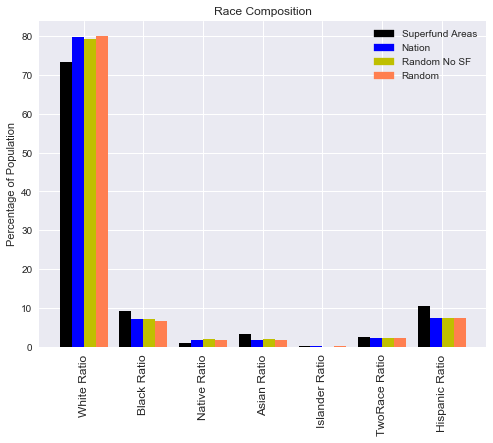

In [38]:
popRatioLabels = ["White Ratio", "Black Ratio","Native Ratio","Asian Ratio","Islander Ratio","TwoRace Ratio","Hispanic Ratio"]

x_axis = np.arange(len(popRatioLabels))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().mean() *100)
    nationRatios.append(censusByZipCd2015_df[p].dropna().mean() *100)
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().mean()*100)
    randomSubsetRatios.append(random_subset[p].dropna().mean()*100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.bar(x_axis, sfRatios,0.2, color="k")
ax.bar(x_axis+0.2, nationRatios, 0.2, color="b")
ax.bar(x_axis+0.4, randomNoSFSubsetRatios, 0.2, color="y")
ax.bar(x_axis+0.6, randomSubsetRatios, 0.2, color="coral")
handles, labels = ax.get_legend_handles_labels()
    
tick_locations = [value + .3 for value in x_axis]
plt.xticks(tick_locations, popRatioLabels, rotation="90", fontsize=12)
plt.title("Race Composition")
plt.ylabel("Percentage of Population")

sfPatch = mpatches.Patch(color="k", label="Superfund Areas")
nationPatch = mpatches.Patch(color="b", label="Nation")
NoSFsubsetPatch = mpatches.Patch(color="y", label="Random No SF")
subsetPatch = mpatches.Patch(color="coral", label="Random")
plt.legend(handles=[sfPatch, nationPatch,NoSFsubsetPatch, subsetPatch])


plt.show()

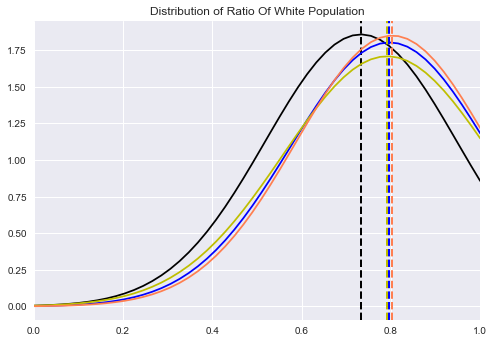

In [65]:
# #white ratio

# plt.hist(sfcensus["White Ratio"].dropna(), normed=True, bins=10, color="k", alpha=.2)
# plt.ylim(0,2)
plt.xlim(0,1)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)
mu, std = stats.norm.fit(sfcensus["White Ratio"].dropna())
p = stats.norm.pdf(x, mu, std)
plt.plot(x,p, "k")
plt.axvline(sfcensus["White Ratio"].mean(), color='k', linestyle='dashed', linewidth=2)

mu, std = stats.norm.fit(censusByZipCd2015_df["White Ratio"].dropna())
p = stats.norm.pdf(x, mu, std)
plt.plot(x,p, "b")
plt.axvline(censusByZipCd2015_df["White Ratio"].mean(), color='b', linestyle='dashed', linewidth=2)

mu, std = stats.norm.fit(no_sf_subset["White Ratio"].dropna())
p = stats.norm.pdf(x, mu, std)
plt.plot(x,p, "y")
plt.axvline(no_sf_subset["White Ratio"].mean(), color='y', linestyle='dashed', linewidth=2)

mu, std = stats.norm.fit(random_subset["White Ratio"].dropna())
p = stats.norm.pdf(x, mu, std)
plt.plot(x,p, "coral")
plt.axvline(random_subset["White Ratio"].mean(), color='coral', linestyle='dashed', linewidth=2)

plt.title("Distribution of Ratio Of White Population")


plt.show()

### Education
#### not normalized

In [41]:
print("SF Mean - Education: %s" % "{:,.0f}".format(sfcensus["Edu_Total"].mean()))
print("Nation Mean - Education: %s" % "{:,.0f}".format(censusByZipCd2015_df["Edu_Total"].mean()))

SF Mean - Education: 9,166
Nation Mean - Education: 4,365


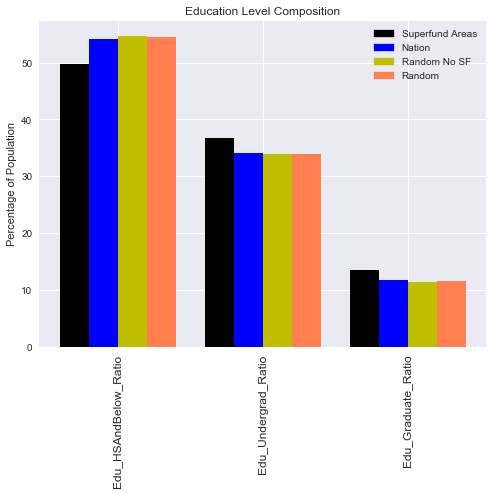

In [42]:
popRatioLabels = ["Edu_HSAndBelow_Ratio", "Edu_Undergrad_Ratio","Edu_Graduate_Ratio"]

x_axis = np.arange(len(popRatioLabels))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().mean() *100)
    nationRatios.append(censusByZipCd2015_df[p].dropna().mean() *100)
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().mean()*100)
    randomSubsetRatios.append(random_subset[p].dropna().mean()*100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.bar(x_axis, sfRatios,0.2, color="k")
ax.bar(x_axis+0.2, nationRatios, 0.2, color="b")
ax.bar(x_axis+0.4, randomNoSFSubsetRatios, 0.2, color="y")
ax.bar(x_axis+0.6, randomSubsetRatios, 0.2, color="coral")
handles, labels = ax.get_legend_handles_labels()
    
tick_locations = [value + .3 for value in x_axis]
plt.xticks(tick_locations, popRatioLabels, rotation="90", fontsize=12)
plt.title("Education Level Composition")
plt.ylabel("Percentage of Population")

sfPatch = mpatches.Patch(color="k", label="Superfund Areas")
nationPatch = mpatches.Patch(color="b", label="Nation")
NoSFsubsetPatch = mpatches.Patch(color="y", label="Random No SF")
subsetPatch = mpatches.Patch(color="coral", label="Random")
plt.legend(handles=[sfPatch, nationPatch,NoSFsubsetPatch, subsetPatch])


plt.show()

#### Education Variables Result: Undergrad and Grad population is higher in Superfund areas

### Economic Variables
#### normalized


In [43]:
print("SF Median income - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["B19013_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).mean())

SF Median income - significant


Ttest_1sampResult(statistic=3.6402901585240923, pvalue=0.00028535203130582539)

In [44]:
print("SF Median income")
# print("SF Min %f" % pd.Series(pd.to_numeric(sfcensus["B19013_001E"].dropna())).min())
# print("SF Max %f" % pd.Series(pd.to_numeric(sfcensus["B19013_001E"].dropna())).max())
# print("Nation Min %f" % pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).min())
# print("Nation Max %f" % pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).max())
print("SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(sfcensus["B19013_001E"].dropna())).mean()))
print("Nation Mean %s" % "${:,.0f}".format(pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).mean()))

SF Median income
SF Mean $55,940 
Nation Mean $53,434


In [45]:
print("SF Income per capita - not signficant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["B19301_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).mean())

SF Income per capita - not signficant


Ttest_1sampResult(statistic=1.229730343971863, pvalue=0.21906468461352607)

In [46]:
print("Income per capita")
# print("SF Min %f" % pd.Series(pd.to_numeric(sfcensus["B19301_001E"].dropna())).min())
# print("SF Max %f" % pd.Series(pd.to_numeric(sfcensus["B19301_001E"].dropna())).max())
# print("Nation Min %f" % pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).min())
# print("Nation Max %f" % pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).max())
print("SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(sfcensus["B19301_001E"].dropna())).mean()))
print("Nation Mean %s" % "${:,.0f}".format(pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).mean()))

Income per capita
SF Mean $27,256 
Nation Mean $26,867


In [47]:
print("Random No SF Subset Median income - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(no_sf_subset["B19013_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).mean())

Random No SF Subset Median income - significant


Ttest_1sampResult(statistic=-1.0176346164185113, pvalue=0.30908853037994893)

In [48]:
print("Random Subset Median income - not significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(random_subset["B19013_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).mean())

Random Subset Median income - not significant


Ttest_1sampResult(statistic=0.96984992705344519, pvalue=0.33234810513975366)

In [49]:
print("Median income")
print("SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(sfcensus["B19013_001E"].dropna())).mean()))
print("Nation Mean %s" % "${:,.0f}".format(pd.to_numeric(censusByZipCd2015_df["B19013_001E"].dropna()).mean()))
print("Random No SF Subset Mean %s" % "${:,.0f}".format(pd.to_numeric(no_sf_subset["B19013_001E"].dropna()).mean()))
print("Random Subset Mean %s" % "${:,.0f}".format(pd.to_numeric(random_subset["B19013_001E"].dropna()).mean()))

Median income
SF Mean $55,940 
Nation Mean $53,434
Random No SF Subset Mean $52,744
Random Subset Mean $54,137


In [50]:
print("Random No SF Subset Income per capita - signficant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(no_sf_subset["B19301_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).mean())

Random No SF Subset Income per capita - signficant


Ttest_1sampResult(statistic=-1.234824161673975, pvalue=0.21716553191142404)

In [51]:
print("Random Subset Income per capita - not signficant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(random_subset["B19301_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).mean())

Random Subset Income per capita - not signficant


Ttest_1sampResult(statistic=0.85464259232346429, pvalue=0.39293928219204588)

In [52]:
print("Income per capita")
print("SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(sfcensus["B19301_001E"].dropna())).mean()))
print("Nation Mean %s" % "${:,.0f}".format(pd.to_numeric(censusByZipCd2015_df["B19301_001E"].dropna()).mean()))
print("Random No SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(no_sf_subset["B19301_001E"].dropna())).mean()))
print("Random Subset Mean %s" % "${:,.0f}".format(pd.to_numeric(random_subset["B19301_001E"].dropna()).mean()))

Income per capita
SF Mean $27,256 
Nation Mean $26,867
Random No SF Mean $26,434 
Random Subset Mean $27,329


#### Economic Variables Result: Median household income is significantly more in Superfund areas; Income per capita is not significantly different - Is family size larger in Superfund areas?

In [53]:
sfcensus["B19013_001E"].dropna().astype('int').mean()


55939.83846872082

In [54]:
sfcensus["B19013_001E"].dropna().astype('int').sum()/len(sfcensus["B19013_001E"].dropna())

55939.838468720824

In [ ]:
no_sf_subset["B19013_001E"].dropna().head()

In [ ]:
random_subset["B19013_001E"].dropna().head()

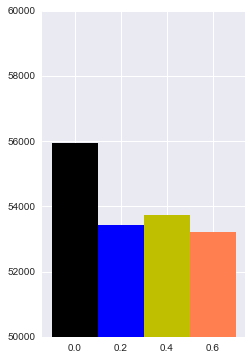

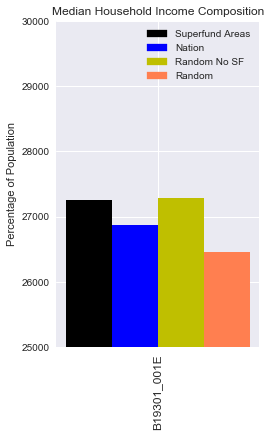

In [72]:
popRatioLabels = ["B19013_001E"]

x_axis = np.arange(len(popRatioLabels))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().astype('int').mean())
    nationRatios.append(censusByZipCd2015_df[p].dropna().astype('int').mean())
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().astype('int').mean())
    randomSubsetRatios.append(random_subset[p].dropna().astype('int').mean())

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,2,1)
ax.bar(x_axis, sfRatios,0.2, color="k")
ax.bar(x_axis+0.2, nationRatios, 0.2, color="b")
ax.bar(x_axis+0.4, randomNoSFSubsetRatios, 0.2, color="y")
ax.bar(x_axis+0.6, randomSubsetRatios, 0.2, color="coral")
handles, labels = ax.get_legend_handles_labels()

popRatioLabels = ["B19301_001E"]

x_axis = np.arange(len(popRatioLabels))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().astype('int').mean())
    nationRatios.append(censusByZipCd2015_df[p].dropna().astype('int').mean())
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().astype('int').mean())
    randomSubsetRatios.append(random_subset[p].dropna().astype('int').mean())
plt.ylim(50000,60000)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,2,2)
ax.bar(x_axis, sfRatios,0.2, color="k")
ax.bar(x_axis+0.2, nationRatios, 0.2, color="b")
ax.bar(x_axis+0.4, randomNoSFSubsetRatios, 0.2, color="y")
ax.bar(x_axis+0.6, randomSubsetRatios, 0.2, color="coral")
handles, labels = ax.get_legend_handles_labels()
plt.ylim(25000,30000)

tick_locations = [value + .3 for value in x_axis]
plt.xticks(tick_locations, popRatioLabels, rotation="90", fontsize=12)
plt.title("Median Household Income Composition")
plt.ylabel("Percentage of Population")

sfPatch = mpatches.Patch(color="k", label="Superfund Areas")
nationPatch = mpatches.Patch(color="b", label="Nation")
NoSFsubsetPatch = mpatches.Patch(color="y", label="Random No SF")
subsetPatch = mpatches.Patch(color="coral", label="Random")
plt.legend(handles=[sfPatch, nationPatch,NoSFsubsetPatch, subsetPatch])


plt.show()

### Employment Status
#### not normalized - determine the ratios

In [82]:
print("SF Employed - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["LaborForce_Emp_Ratio"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["LaborForce_Total"].dropna()).mean())

SF Employed - significant


Ttest_1sampResult(statistic=-2609801.8425054904, pvalue=0.0)

In [83]:
print("Random No SF Subset Employed - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(no_sf_subset["LaborForce_Emp_Ratio"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["LaborForce_Total"].dropna()).mean())

Random No SF Subset Employed - significant


Ttest_1sampResult(statistic=-2058292.7818144397, pvalue=0.0)

In [84]:
print("Random Subset Employed - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(random_subset["LaborForce_Emp_Ratio"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["LaborForce_Total"].dropna()).mean())

Random Subset Employed - significant


Ttest_1sampResult(statistic=-1987970.8007191923, pvalue=0.0)

In [85]:
print("SF Employment Rate %f" % (sfcensus["LaborForce_Emp_Ratio"].mean()*100))
print("Nation Employment Rate %f" % (censusByZipCd2015_df["LaborForce_Emp_Ratio"].mean()*100))
print("Random No SF Subset SF Employment Rate %f" % (no_sf_subset["LaborForce_Emp_Ratio"].mean()*100))
print("Random Employment Rate %f" % (random_subset["LaborForce_Emp_Ratio"].mean()*100))

SF Employment Rate 63.436950
Nation Employment Rate 60.011797
Random No SF Subset SF Employment Rate 59.671063
Random Employment Rate 59.894473


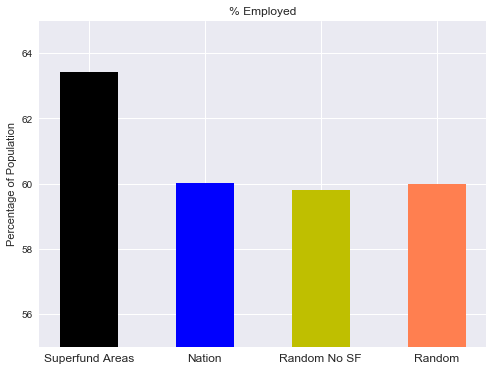

In [120]:
popRatioLabels = ["LaborForce_Emp_Ratio"]

x_axis = np.arange(len(groups))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().mean() *100)
    nationRatios.append(censusByZipCd2015_df[p].dropna().mean() *100)
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().mean()*100)
    randomSubsetRatios.append(random_subset[p].dropna().mean()*100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.bar(x_axis[0], sfRatios,0.5, color="k")
ax.bar(x_axis[1], nationRatios, 0.5, color="b")
ax.bar(x_axis[2], randomNoSFSubsetRatios, 0.5, color="y")
ax.bar(x_axis[3], randomSubsetRatios, 0.5, color="coral")
handles, labels = ax.get_legend_handles_labels()
    
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, groups, fontsize=12)
plt.title("% Employed")
plt.ylabel("Percentage of Population")
plt.ylim(55,65)

plt.show()

#### Employment Status Result: Employment percentage is significantly higher in Superfund area

In [ ]:
# look at types of jobs?

In [ ]:
# multiply employment rate by population?

### Housing
#### normalized

In [ ]:
print("SF Median home value - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["B25077_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B25077_001E"].dropna()).mean())

In [ ]:
print("Random No SF Subset Median home value - significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(no_sf_subset["B25077_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B25077_001E"].dropna()).mean())

In [ ]:
print("Random Subset Median home value - not significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(random_subset["B25077_001E"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["B25077_001E"].dropna()).mean())

In [ ]:
print("Median home value")
print("SF Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(sfcensus["B25077_001E"].dropna())).mean()))
print("Nation Mean %s" % "${:,.0f}".format(pd.to_numeric(censusByZipCd2015_df["B25077_001E"].dropna()).mean()))
print("Random No SF Subset Mean %s " % "${:,.0f}".format(pd.Series(pd.to_numeric(no_sf_subset["B25077_001E"].dropna())).mean()))
print("Random Subset Mean %s" % "${:,.0f}".format(pd.to_numeric(random_subset["B25077_001E"].dropna()).mean()))

In [ ]:
# B25088_002E - median_monthly_owner_costs
# B25064_001E - gross rent
# B19013_001E - median hh income
# print("Percentage of income towards housing")
# sfcensus["B25088_002E"] = pd.to_numeric(sfcensus["B25088_002E"]) 
# censusByZipCd2015_df["B25088_002E"] = pd.to_numeric(censusByZipCd2015_df["B25088_002E"])
# sfcensus["B25064_001E"] = pd.to_numeric(sfcensus["B25064_001E"]) 
# censusByZipCd2015_df["B25064_001E"] = pd.to_numeric(censusByZipCd2015_df["B25064_001E"])

# no_sf_subset["B25088_002E"] = pd.to_numeric(no_sf_subset["B25088_002E"]) 
# random_subset["B25088_002E"] = pd.to_numeric(random_subset["B25088_002E"]) 
# no_sf_subset["B25064_001E"] = pd.to_numeric(no_sf_subset["B25064_001E"]) 
# random_subset["B25064_001E"] = pd.to_numeric(random_subset["B25064_001E"]) 

# sfcensus["incomeOwning"] = (sfcensus["B25088_002E"]*12)/pd.to_numeric(sfcensus["B19013_001E"])
# censusByZipCd2015_df["incomeOwning"] = (censusByZipCd2015_df["B25088_002E"]*12)/pd.to_numeric(censusByZipCd2015_df["B19013_001E"])
# no_sf_subset["incomeOwning"] = (no_sf_subset["B25088_002E"]*12)/pd.to_numeric(no_sf_subset["B19013_001E"])
# random_subset["incomeOwning"] = (random_subset["B25088_002E"]*12)/pd.to_numeric(random_subset["B19013_001E"])

# sfcensus["incomeRenting"] = (sfcensus["B25064_001E"]*12)/pd.to_numeric(sfcensus["B19013_001E"])
# censusByZipCd2015_df["incomeRenting"] = (censusByZipCd2015_df["B25064_001E"] * 12)/pd.to_numeric(censusByZipCd2015_df["B19013_001E"])
# no_sf_subset["incomeRenting"] = (no_sf_subset["B25064_001E"]*12)/pd.to_numeric(no_sf_subset["B19013_001E"])
# random_subset["incomeRenting"] = (random_subset["B25064_001E"] * 12)/pd.to_numeric(random_subset["B19013_001E"])


print("SF Owning percentage of income towards housing - Significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["incomeOwning"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["incomeOwning"].dropna()).mean())

In [ ]:
print("Random No SF Subset SF Renting percentage of income towards housing - WILDLY significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(no_sf_subset["incomeOwning"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["incomeRenting"].dropna()).mean())

In [ ]:
print("Random Subset SF Renting percentage of income towards housing - WILDLY significant")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(random_subset["incomeOwning"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["incomeRenting"].dropna()).mean())

In [ ]:
print("SF Renting percentage of income towards housing")
stats.ttest_1samp(a=pd.Series(pd.to_numeric(sfcensus["incomeRenting"].dropna())), popmean=pd.to_numeric(censusByZipCd2015_df["incomeRenting"].dropna()).mean())

In [ ]:
print("Percentage of income towards housing - owning")
print("SF Mean %s " % "{:,.2f}%".format(pd.Series(pd.to_numeric(sfcensus["incomeOwning"].dropna())).mean()*100))
print("Nation Mean %s" % "{:,.2f}%".format(pd.to_numeric(censusByZipCd2015_df["incomeOwning"].dropna()).mean()*100))
print("Random No SF Subset Mean %s " % "{:,.2f}%".format(pd.Series(pd.to_numeric(no_sf_subset["incomeOwning"].dropna())).mean()*100))
print("Random Subset Mean %s" % "{:,.2f}%".format(pd.to_numeric(random_subset["incomeOwning"].dropna()).mean()*100))

print("Percentage of income towards housing - renting")
print("SF Mean %s " % "{:,.2f}%".format(pd.Series(pd.to_numeric(sfcensus["incomeRenting"].dropna())).mean()*100))
print("Nation Mean %s" % "{:,.2f}%".format(pd.to_numeric(censusByZipCd2015_df["incomeRenting"].dropna()).mean()*100))

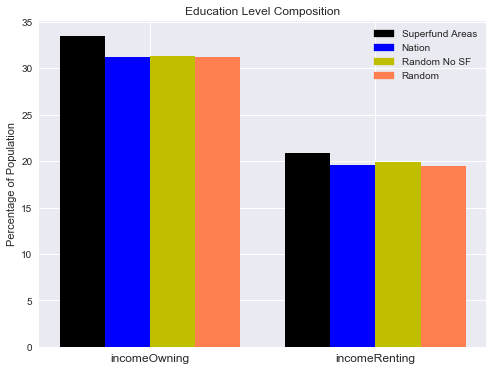

In [124]:
popRatioLabels = ["incomeOwning","incomeRenting"]

x_axis = np.arange(len(popRatioLabels))
sfRatios = []
nationRatios = []
randomNoSFSubsetRatios = []
randomSubsetRatios = []
for p in popRatioLabels:
    sfRatios.append(sfcensus[p].dropna().mean() *100)
    nationRatios.append(censusByZipCd2015_df[p].dropna().mean() *100)
    randomNoSFSubsetRatios.append(no_sf_subset[p].dropna().mean()*100)
    randomSubsetRatios.append(random_subset[p].dropna().mean()*100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.bar(x_axis, sfRatios,0.2, color="k")
ax.bar(x_axis+0.2, nationRatios, 0.2, color="b")
ax.bar(x_axis+0.4, randomNoSFSubsetRatios, 0.2, color="y")
ax.bar(x_axis+0.6, randomSubsetRatios, 0.2, color="coral")
handles, labels = ax.get_legend_handles_labels()
    
tick_locations = [value + .3 for value in x_axis]
plt.xticks(tick_locations, popRatioLabels, fontsize=12)
plt.title("Education Level Composition")
plt.ylabel("Percentage of Population")

sfPatch = mpatches.Patch(color="k", label="Superfund Areas")
nationPatch = mpatches.Patch(color="b", label="Nation")
NoSFsubsetPatch = mpatches.Patch(color="y", label="Random No SF")
subsetPatch = mpatches.Patch(color="coral", label="Random")
plt.legend(handles=[sfPatch, nationPatch,NoSFsubsetPatch, subsetPatch])


plt.show()

#### Housing Result: Median home value is significantly higher in areas with Superfund sites

In [ ]:
# sns.distplot(sfcensus["White Ratio"], hist=False, rug=True, color="k");
# sns.distplot(censusByZipCd2015_df["White Ratio"], hist=False, rug=True, color="b");
# sns.distplot(no_sf_subset["White Ratio"], hist=False, rug=True, color="y");
# sns.distplot(random_subset["White Ratio"], hist=False, rug=True, color="coral");
# plt.show()